<a href="https://colab.research.google.com/github/Igor-Belskiy/AI_University/blob/main/%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D0%B8_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_(Light).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работа осуществляется с базой акции Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

# Загрузка библиотек и данных

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [2]:
!rm -rf *      # Удаление всех каталогов и файлов в текущей директории

In [3]:
# Загружаем данные в колаб

import gdown
gdown.download('https://drive.google.com/uc?id=1g6CCPyp_UejO9O6Lon6KdL3fOVGGsCxz', '16_17.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1Xk250F0NjfIaTrMgCFiEmo-qQ1ydf8Gq', '18_19.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1g6CCPyp_UejO9O6Lon6KdL3fOVGGsCxz
To: /content/16_17.csv
100%|██████████| 12.9M/12.9M [00:00<00:00, 86.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xk250F0NjfIaTrMgCFiEmo-qQ1ydf8Gq
To: /content/18_19.csv
100%|██████████| 10.7M/10.7M [00:00<00:00, 192MB/s]


'18_19.csv'

In [4]:
#Считываем данные с помощью pandas

base_data_18_19 = pd.read_csv('/content/18_19.csv', sep=';')
base_data_16_17 = pd.read_csv('/content/16_17.csv', sep=';')

In [5]:
#Выводим пять первых строк
base_data_18_19.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [6]:
base_data_16_17.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


In [7]:
# Смотрим размер загруженных из файлов данных

print(base_data_16_17.shape)
print(base_data_18_19.shape)

(263925, 7)
(217947, 7)


In [8]:
data = pd.concat([base_data_16_17, base_data_18_19])  # Объединяем базы в одну

data.shape

(481872, 7)

In [9]:
#Оставляем для дальнейшей работы только последние 5 столбцов
data = data.iloc[:,2:]

data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [10]:
data = np.array(data)   #Превращаем в numpy массив

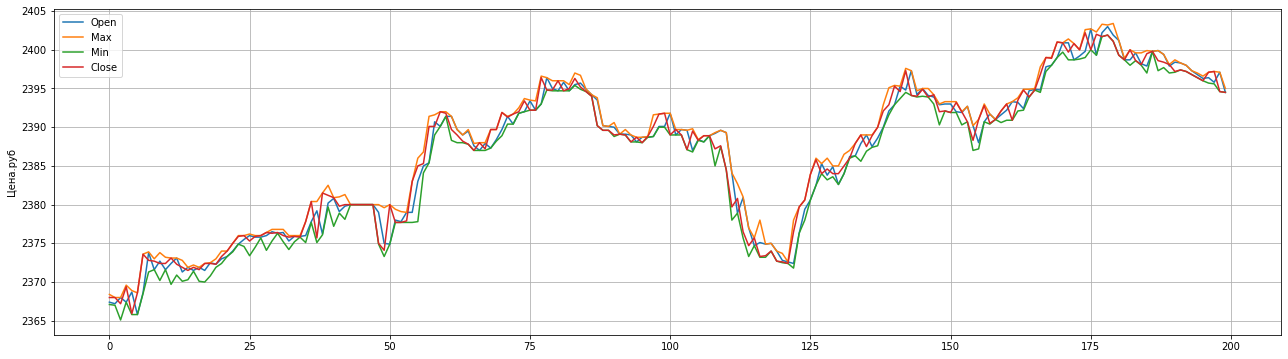

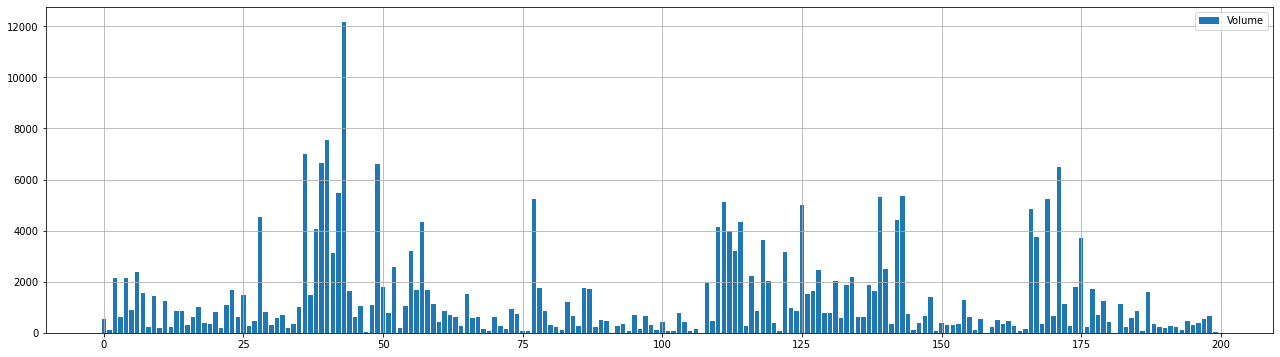

In [11]:
#Отображаем исходные данные от точки start и длинной length
start = 1000            #С какой точки начинаем
length = 200           #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
plt.figure(figsize=(22,6))
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+length,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.grid()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.grid()
plt.show()

# Функции визуализации результатов

In [12]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

In [13]:
# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

In [14]:
# Функция рисует корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  plt.figure(figsize=(14,7))
  
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i шагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append( np.corrcoef(yValUnscaled[:yLen-i,ch], predVal[i:, 0])[0][1] )

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append( np.corrcoef(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch])[0][1] )

    # Отображаем график коррелций для данного шага
    
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

# Эксперимент 1: Danse. Прогнозируем на 1 шаг вперёд

In [15]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen-xLen-2 # Размер тренировочной выборки

trainLen

451570

In [16]:
#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

print(xTrain.shape)
print(xTest.shape)

(451570, 5)
(30000, 5)


In [17]:
#Масштабируем данные (отдельно для X и Y)
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

In [18]:
#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1, sampling_rate=1,
                               batch_size=20)

In [19]:
# Смотрим размерность данных в полученном генераторе

trainDataGen[0][0].shape

(20, 300, 5)

In [20]:
trainDataGen[0][1].shape

(20, 1)

In [21]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [22]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="relu" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

modelD.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300, 150)          900       
                                                                 
 flatten (Flatten)           (None, 45000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=5, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/5
22564/22564 [==============================] - 72s 3ms/step - loss: 6.7668e-04 - val_loss: 2.6517e-04
Epoch 2/5
22564/22564 [==============================] - 69s 3ms/step - loss: 6.0273e-05 - val_loss: 1.5467e-04
Epoch 3/5
22564/22564 [==============================] - 68s 3ms/step - loss: 3.6533e-05 - val_loss: 2.2541e-05
Epoch 4/5
22564/22564 [==============================] - 68s 3ms/step - loss: 3.0586e-05 - val_loss: 1.7865e-04
Epoch 5/5
22564/22564 [==============================] - 68s 3ms/step - loss: 2.3472e-05 - val_loss: 1.4727e-05


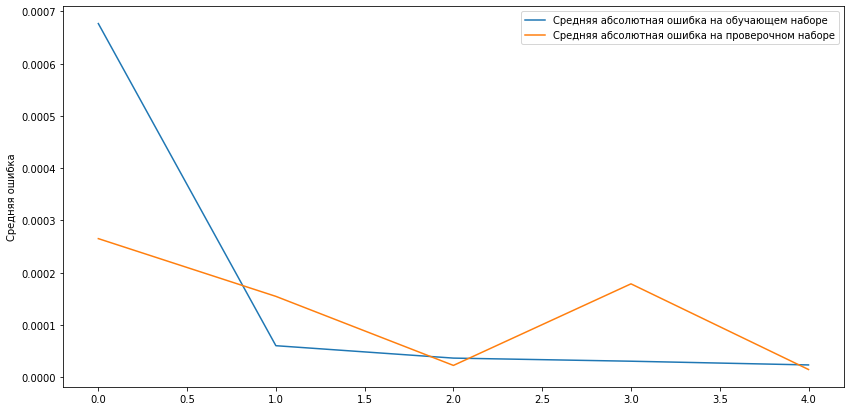

In [24]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

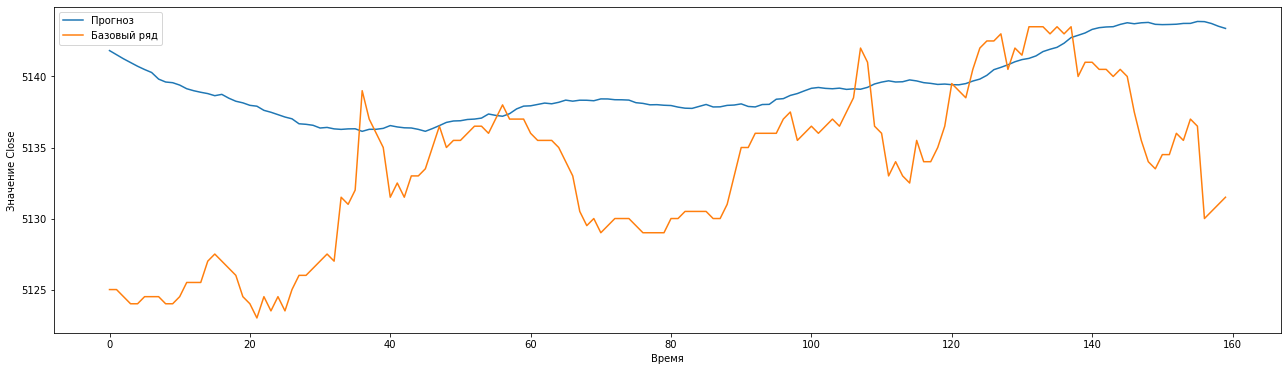

In [25]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

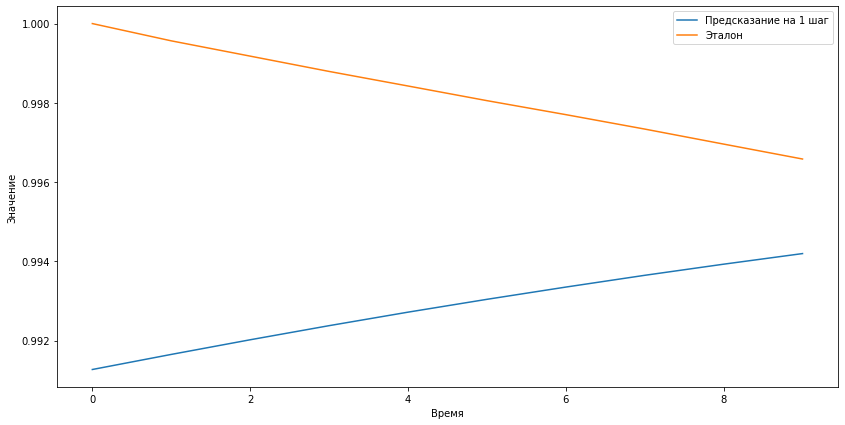

In [26]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

# Эксперимент 2: Danse. Прогнозируем на 10 шагов вперед

In [27]:
#Формируем параметры загрузки данных
xLen = 300                       #Анализируем по 300 прошедшим точкам 
valLen = 30000                   #Используем 30000 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,3][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,3][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [28]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [29]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 10)


In [30]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

In [31]:
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=5, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/5
22579/22579 [==============================] - 70s 3ms/step - loss: 0.0270 - val_loss: 0.0042
Epoch 2/5
22579/22579 [==============================] - 69s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/5
22579/22579 [==============================] - 69s 3ms/step - loss: 4.0479e-04 - val_loss: 3.6629e-04
Epoch 4/5
22579/22579 [==============================] - 69s 3ms/step - loss: 3.0730e-04 - val_loss: 6.7180e-04
Epoch 5/5
22579/22579 [==============================] - 68s 3ms/step - loss: 2.6296e-04 - val_loss: 2.8627e-04


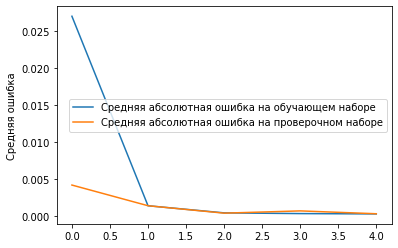

In [32]:
#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [33]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные


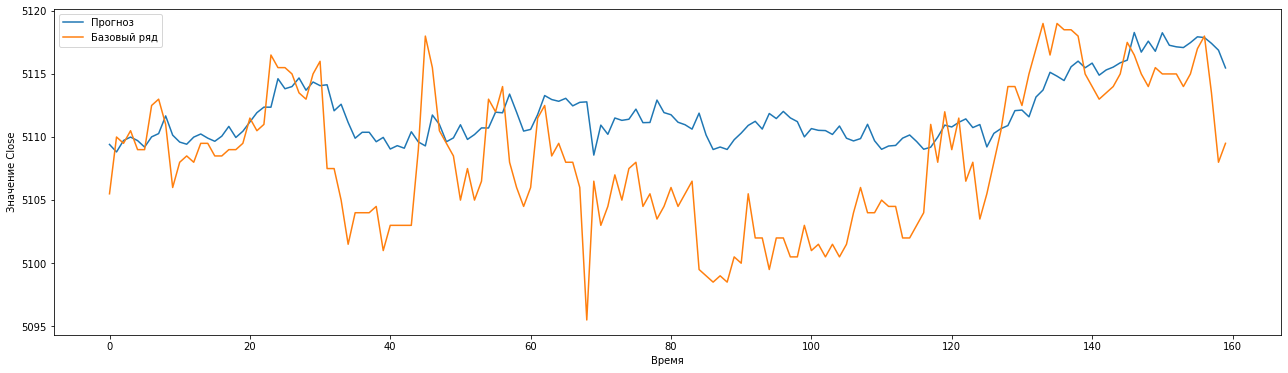

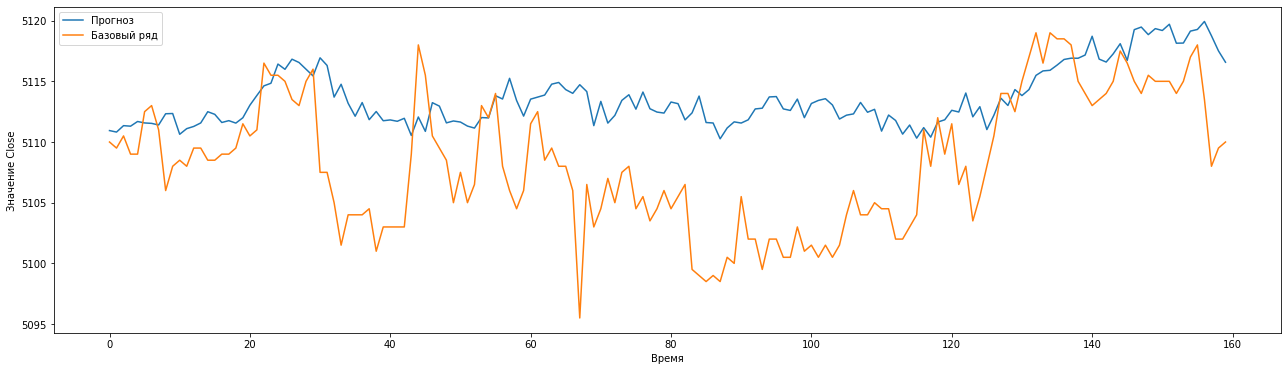

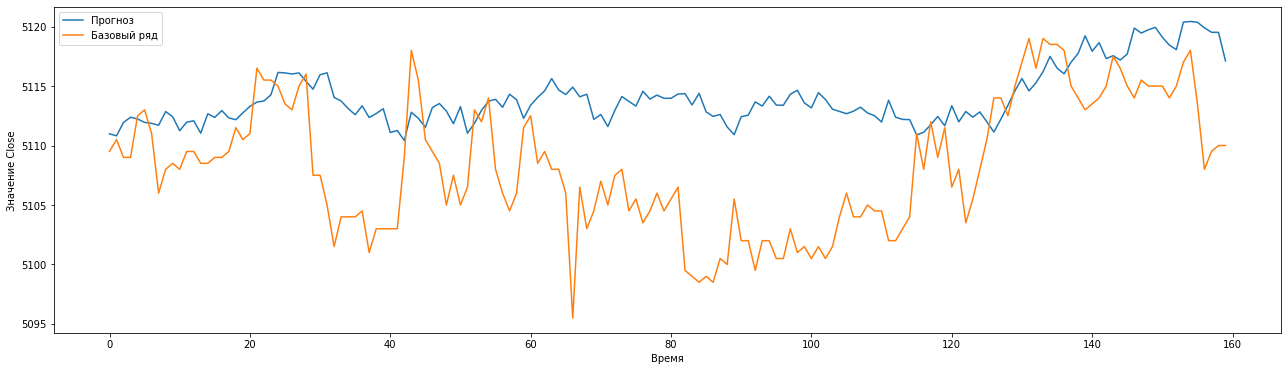

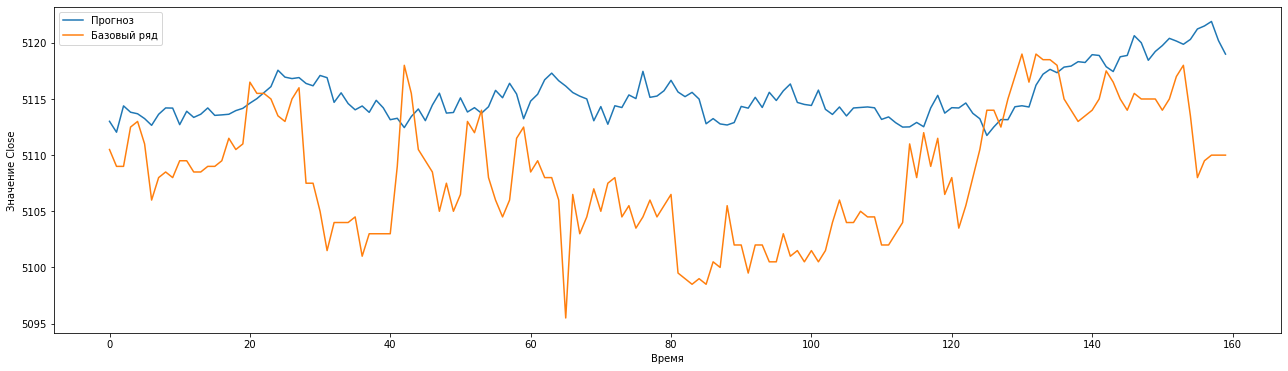

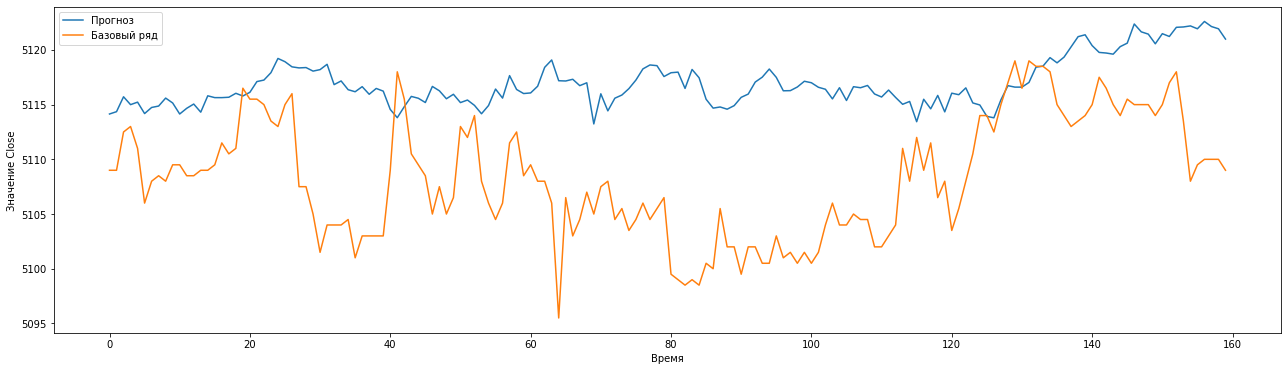

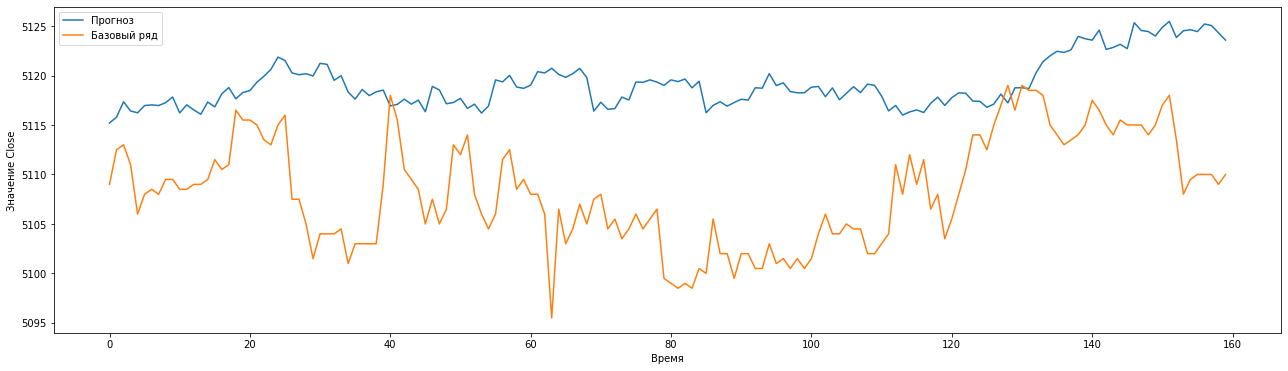

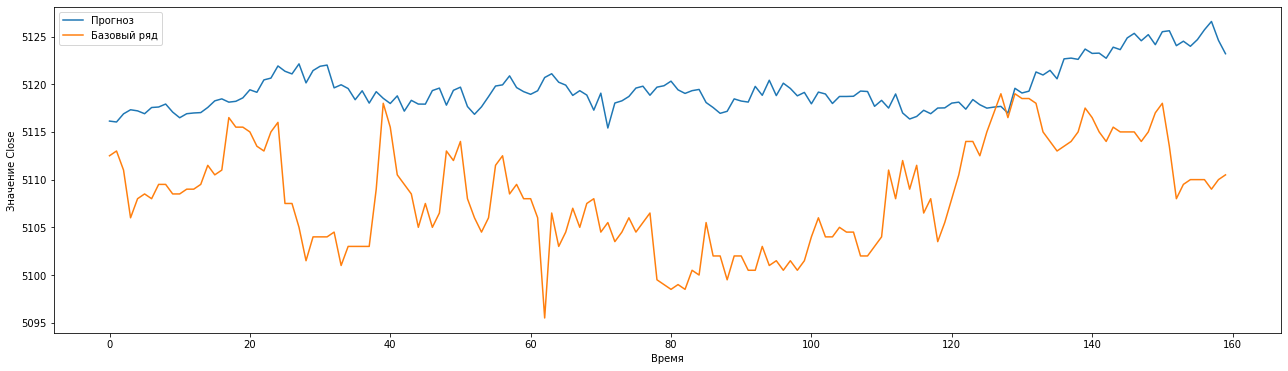

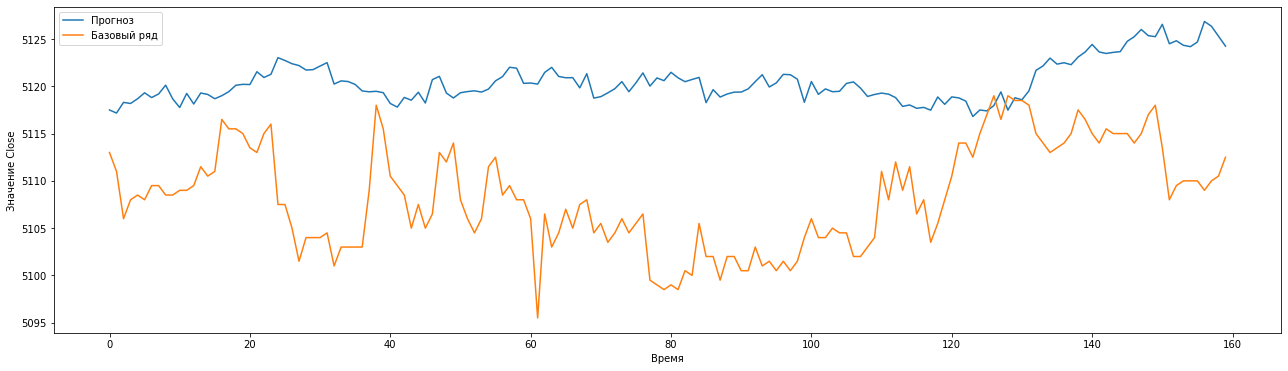

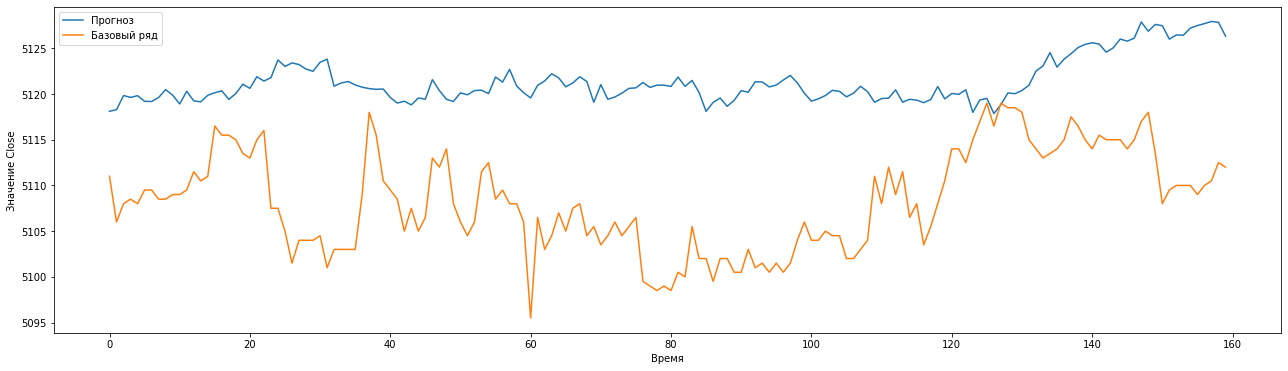

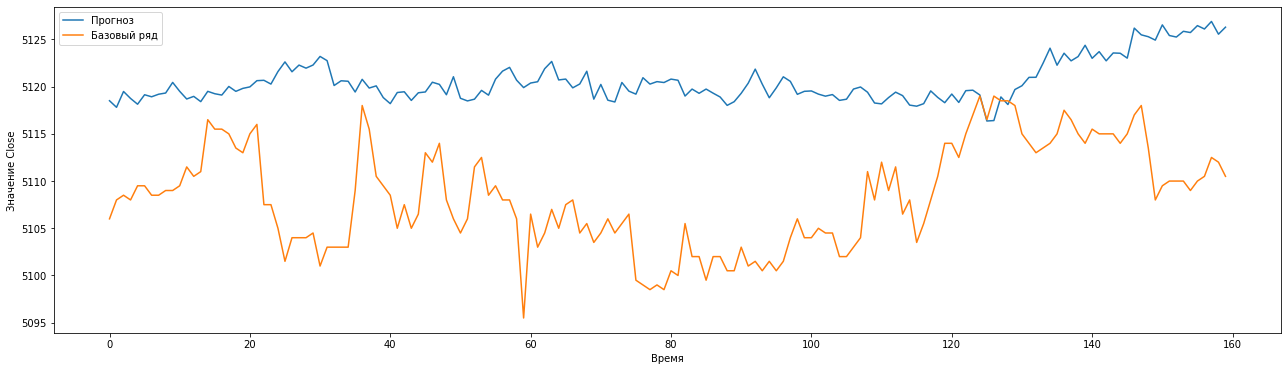

In [34]:
#Отображаем графики
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)


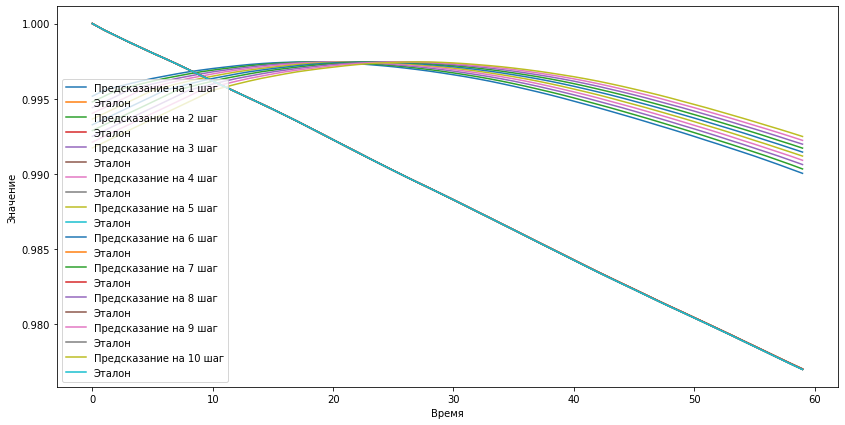

In [35]:
#Отображаем корреляцию
#Используем выходной канал - только close
#Проверяем корреляцию на глубину 60 шагов
showCorr([x for x in range(10)], 60, predVal, yValUnscaled)

# Эксперимент 3: Conv1D. Прогнозируем на 10 шагов вперед

In [36]:
# Создаём сесть 

modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))
modelD.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 300, 150)          900       
                                                                 
 flatten_1 (Flatten)         (None, 45000)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                450010    
                                                                 
Total params: 450,910
Trainable params: 450,910
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
22579/22579 [==============================] - 103s 4ms/step - loss: 0.2068 - val_loss: 0.0020
Epoch 2/5
22579/22579 [==============================] - 92s 4ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/5
22579/22579 [==============================] - 92s 4ms/step - loss: 0.0022 - val_loss: 7.9454e-04
Epoch 4/5
22579/22579 [==============================] - 93s 4ms/step - loss: 0.0016 - val_loss: 4.3028e-04
Epoch 5/5
22579/22579 [==============================] - 92s 4ms/step - loss: 0.0023 - val_loss: 5.5773e-04


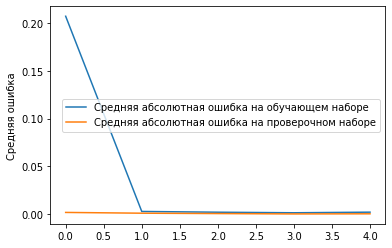

In [37]:
# Обучаем и выводим графики ошибки обучения

history = modelC.fit_generator(trainDataGen,
                    epochs=5, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [38]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

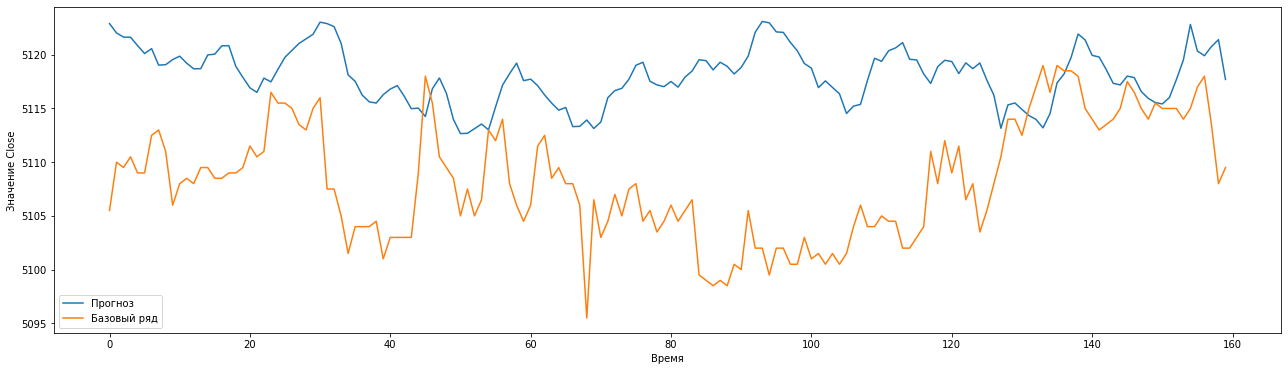

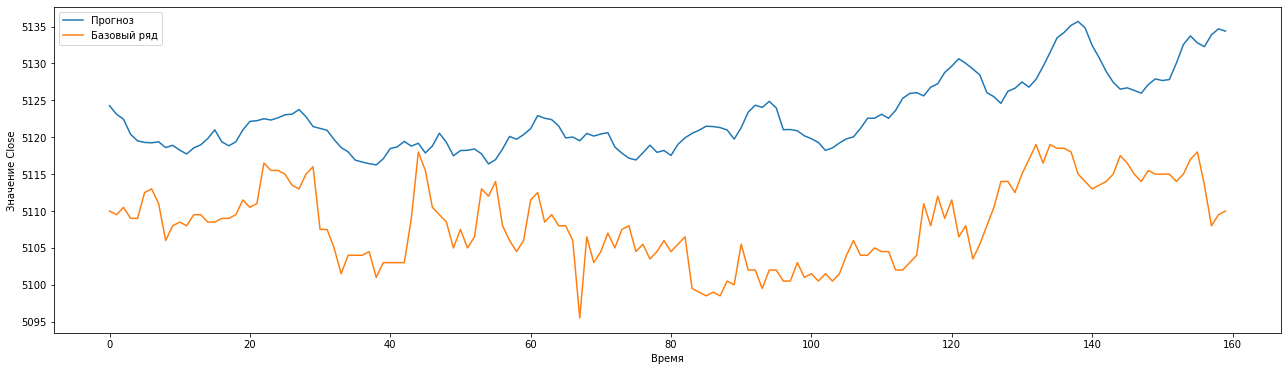

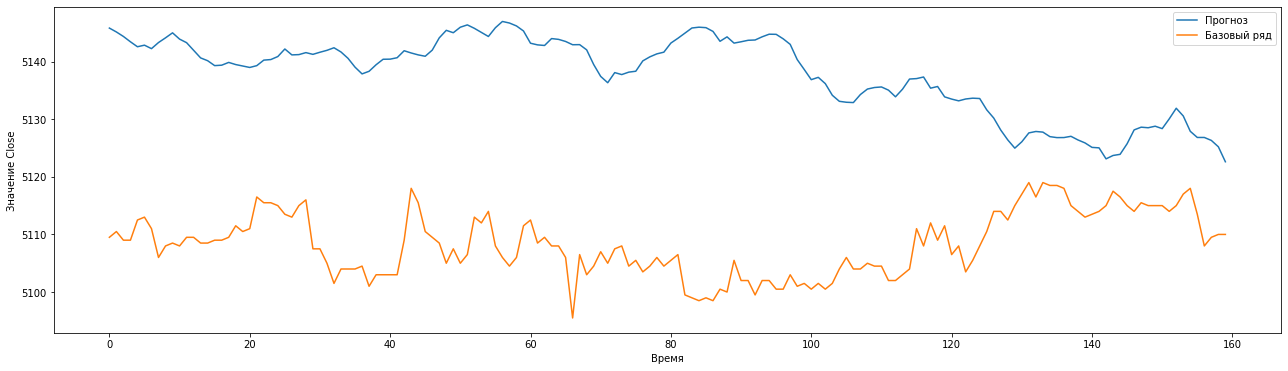

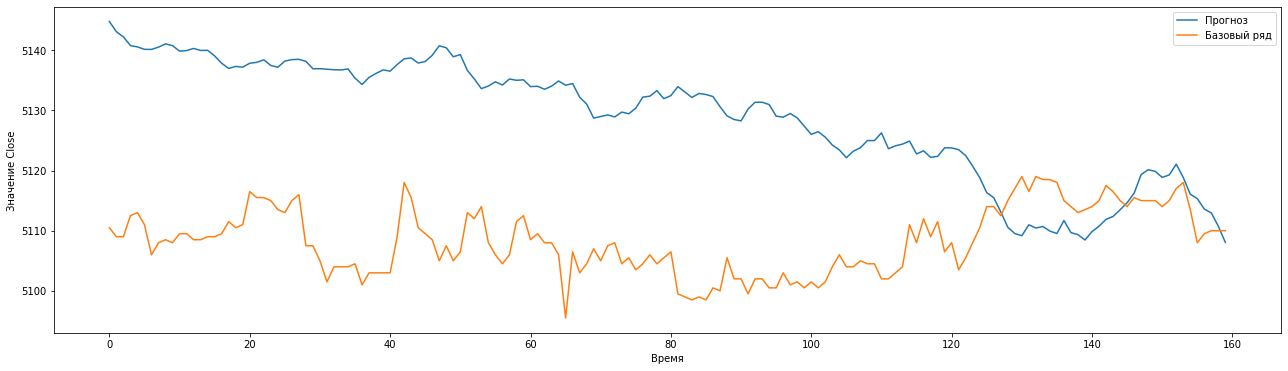

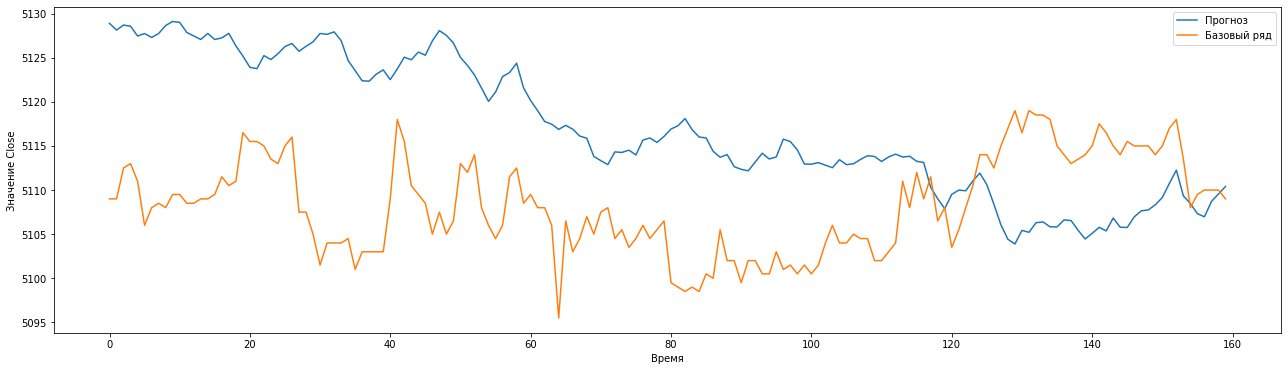

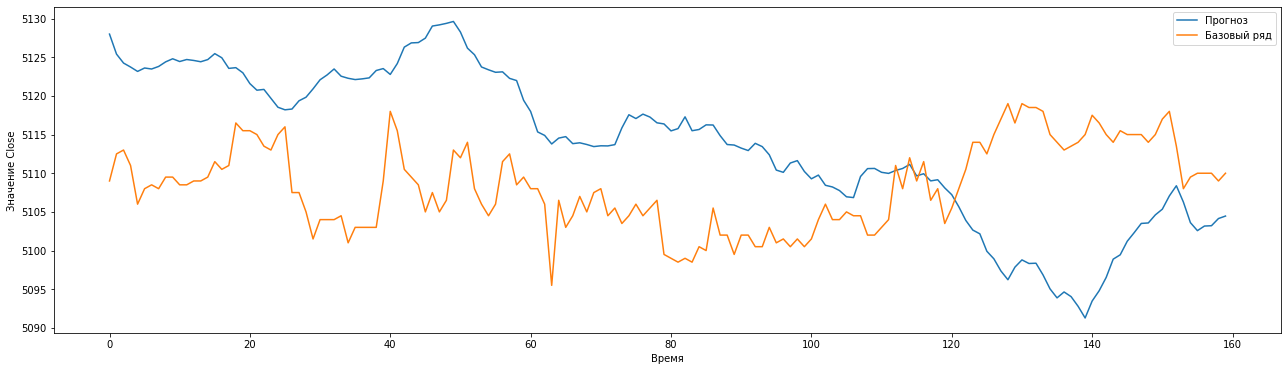

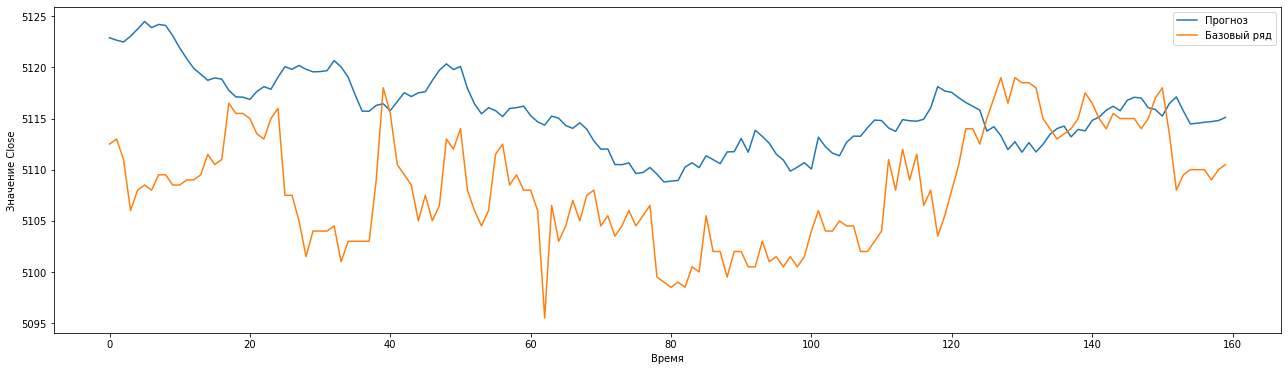

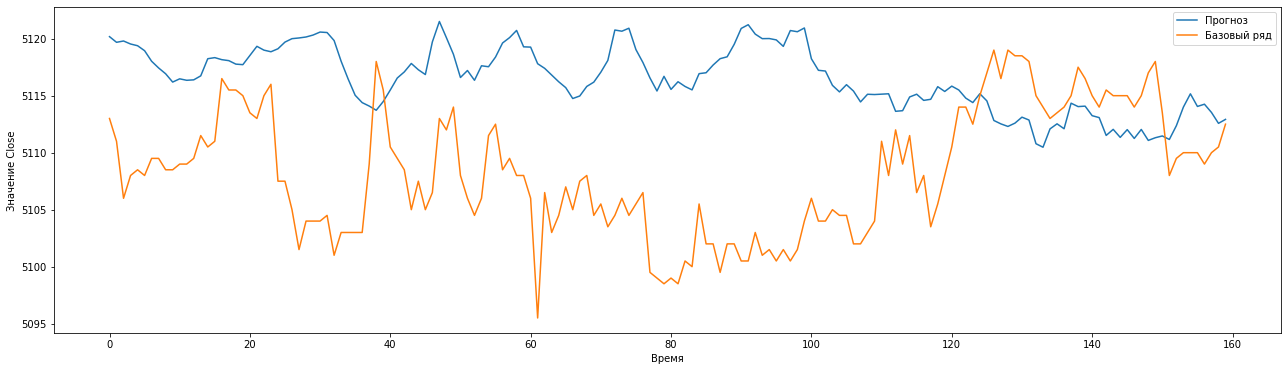

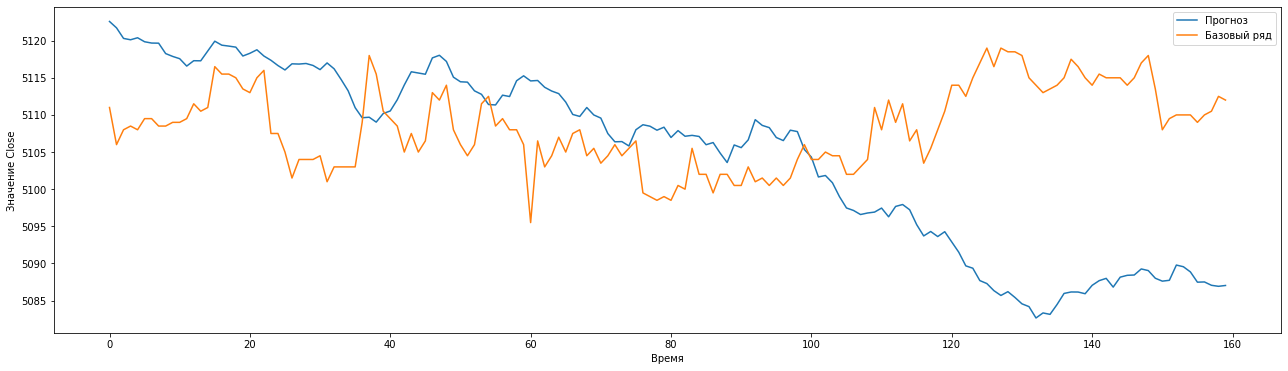

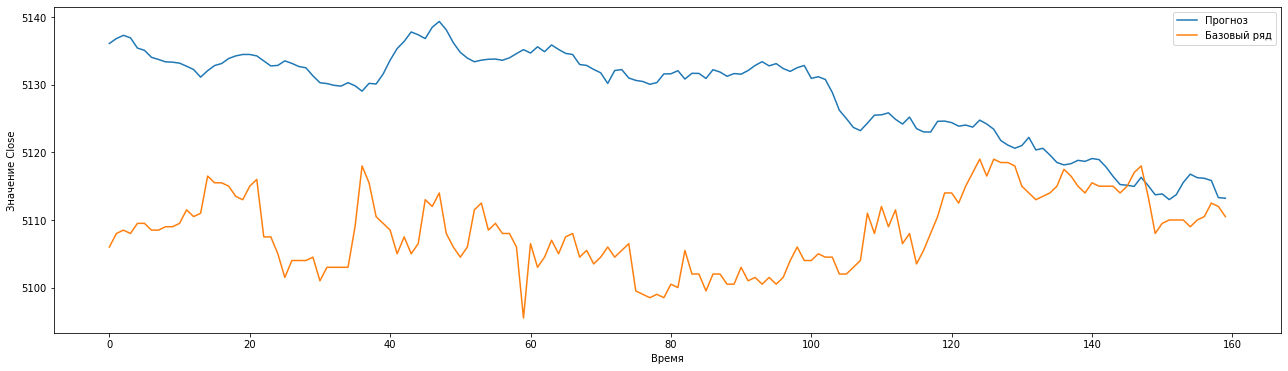

In [39]:
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

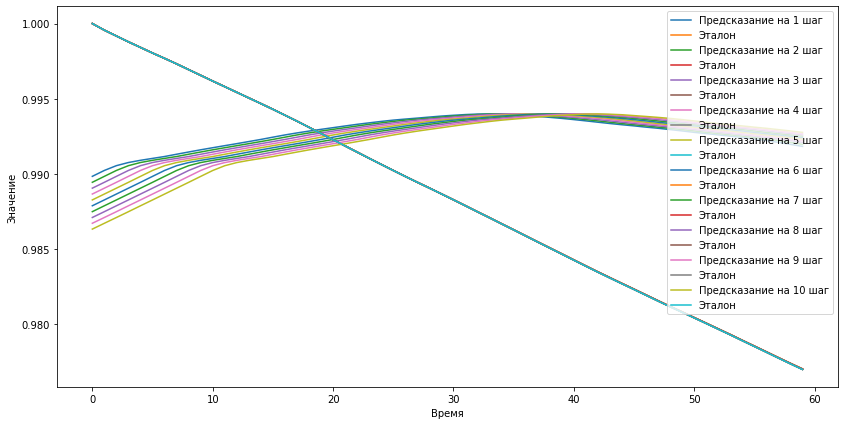

In [40]:
#Отображаем корреляцию
showCorr([x for x in range(10)], 60, predVal, yValUnscaled)